# Node Classification

Build a GNN to predict the subject area for each paper in a citation graph of scientific papers. This is an example of a GNN that does node classification.

Most scientific research is usually based heavily on previous work, and it is common for authors to give credit for such work in their papers in the form of citations. This forms a citation graph. In this graph each node represents a scientific paper, and each edge represents a citation from one paper to another. In addition, each node has a feature vector associated with it.

For this example, use the [CORA Dataset](https://relational.fit.cvut.cz/dataset/CORA) available from the `torch_geometric.datasets.Planetoid` package.

## Setup

The following two cells import Pytorch Geometric (PyG) and a couple of supporting Pytorch packages that are customized against the torch version.

In [1]:
import torch
torch.__version__

'1.9.0+cu111'

In [2]:
!pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-1.9.0+cu111.html
!pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-1.9.0+cu111.html
!pip install -q torch-geometric

     |████████████████████████████████| 10.4 MB 4.1 MB/s 
     |████████████████████████████████| 3.7 MB 4.3 MB/s 
     |████████████████████████████████| 325 kB 4.0 MB/s 
     |████████████████████████████████| 407 kB 36.3 MB/s 
     |████████████████████████████████| 45 kB 3.6 MB/s 


## Dataset

The website for the CORA dataset provides the following information:

> The CORA dataset consists of 2708 scientific publications classified into one of seven classes. The citation network consists of 5429 links. Each publication in the dataset is described by a 0/1-valued word vector indicating the absence/presence of the corresponding word from the dictionary. The dictionary consists of 1433 unique words.

* Load the dataset from the `torch_geometric.datasets.Planetoid` package using the defaults.
* The CORA dataset is a single graph consisting of multiple nodes. Verify that the number of graphs (given by the `torch_geometric.data.Data` object) is 1.
* Each node is associated with a feature vector that is basically a word vector indicating presence or absence of a word from a fixed size dictionary. Find and report the size of each node's feature vector.
* Find the number of subject areas the nodes are classified into, i.e. the number of classes.
* Inspect the underlying Data object representing the graph.
* Count and report the number of nodes in the training, validation, and test sets (Hint: count the number of `True` entries in each mask in the `Data` object).

In [3]:
import torch_geometric

In [4]:
from torch_geometric.datasets import Planetoid

dataset = Planetoid(root="cora", name="Cora")
dataset

Processing...
Done!


Cora()

In [5]:
dataset.num_features

1433

In [6]:
dataset.num_classes

7

In [7]:
dataset[0]

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [8]:
dataset[0].train_mask.count_nonzero()

tensor(140)

In [9]:
dataset[0].val_mask.count_nonzero()

tensor(500)

In [10]:
dataset[0].test_mask.count_nonzero()

tensor(1000)

## DataLoader

Create the train, validation and test DataLoaders (`torch_geometric.loader.DataLoader`). You will need them when building your training and evaluation steps later.

Set the `batch_size` attribute of your `DataLoader` objects to `BATCH_SIZE`.

In [12]:
BATCH_SIZE = 32

In [13]:
from torch_geometric.loader import DataLoader

train_loader = DataLoader(dataset, batch_size=BATCH_SIZE)
val_loader = DataLoader(dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(dataset, batch_size=BATCH_SIZE)

## Model

Now define the GNN network -- like any Pytorch network, it should subclass `torch.nn.Module`.

As shown in the image below, the GNN should consist of 3 GCN ( `torch_geometric.nn.GCNConv`) layers, followed by a classifier head consisting of 2 Linear (`torch.nn.Linear`) layers. Notice the similarity to a CNN.

Each GCNConv layer is followed by a ReLU activation and a Dropout function. The dropout percentage is provided via the constructor.

The two linear layers have a Dropout layer in between them. The linear layer is followed by a `log_softmax` activation function.

Your constructor should accept the `input_dim` (the number of node features), `hidden_dim`, `output_dim` (the number of classes) and the `dropout_pct`. You can use the same `dropout_pct` value for all Dropout layers in the network.

Note that in addition to the node feature vectors (the `Data.x` values) in each batch, the graph layers takes the `edge_index` as well (the `Data.edge_index`).

The diagram below shows the input and output dimensionality for each layer.

---
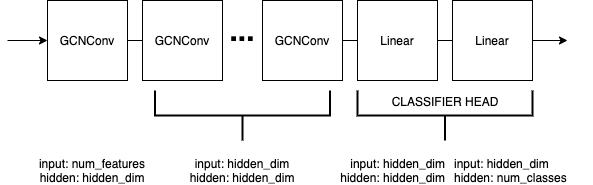

In [15]:
import torch.nn as nn
import torch.nn.functional as F

from torch_geometric.nn import GCNConv


class NodeClassifier(nn.Module):
  def __init__(self, input_dim, num_graph_layers, hidden_dim, output_dim, dropout_pct):

    super(NodeClassifier, self).__init__()

    self.input_dim = input_dim
    self.hidden_dim = hidden_dim
    self.num_graph_layers = num_graph_layers

    self.convs = nn.ModuleList()
    self.convs.append(GCNConv(input_dim, hidden_dim))
    for i in range(num_graph_layers - 1):
      self.convs.append(GCNConv(hidden_dim, hidden_dim))

    self.dropout_pct = dropout_pct

    self.clf_head = nn.Sequential(
      nn.Linear(hidden_dim, hidden_dim),
      nn.Dropout(dropout_pct),
      nn.Linear(hidden_dim, output_dim)
    )

  def forward(self, data):
    x, edge_index, batch = data.x, data.edge_index, data.batch
    
    for i in range(self.num_graph_layers):
      x = self.convs[i](x, edge_index)
      x = F.relu(x)
      x = F.dropout(x, p=self.dropout_pct)
    
    x = self.clf_head(x)
    return F.log_softmax(x, dim=1)

  def loss(self, pred, label):
    return F.nll_loss(pred, label)


## Training Loop

Now define the training loop. One way to do so is to define the training loop as follows#

```
for epoch in epochs:
    train_step()
    eval_step()
```

where the `train_step()` trains the model in batches for one epoch, i.e. the batches run through the data once. The function is defined as follows:

```
def train_step(model: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               train_loader: torch_geometric.loaders.DataLoader,
               device: torch.Device
               ) -> 
               train_loss: Float, 
               train_accuracy: Float
```

Compute the loss and accuracy for each batch, then return the loss and accuracy over the entire epoch.

Similarly, the `eval_step()` evaluates the model in batches for one epoch, i.e. for the entire evaluation dataset. The function can be defined as shown below. As with the `train_step()` function, compute and return the eval loas and accuracy over each epoch.

Note that you can reuse the same function to report validation and test loss and accuracy, by appropriately setting the `eval_loader` and setting the `is_validation` flag.

```
def eval_step(model: torch.nn.Module,
              eval_loader: torch_geometric.loaders.DataLoader,
              device: torch.Device,
              is_validation=False: bool
             ) ->
             val_or_test_loss: Float,
             val_or_test_acc: Float 
```

In the `train_loop()` method, accumulate the training and validation accuracies and loss and return them as a list of tuples. Run the loop for `num_epochs` epochs, and report the losses and accuracies every N epochs. A suggested signature for the `train_loop()` method is as follows.

```
def train_loop(model: torch.nn.Module, 
               optimizer: torch.optim.Optimizer, 
               train_loader: torch_gemetric.loaders.DataLoader,
               val_loader: torch_gemetric.loaders.DataLoader,
               device: torch.Device, 
               num_epochs: Long, 
               log_every=50: Long
              ) ->
              List[(Float, Float, Float, Float)] 
```

In [16]:
def train_step(model, optimizer, train_loader, device):
  model.train()
  total_rows, total_loss, total_correct = 0, 0, 0
  for batch in train_loader:
    batch = batch.to(device)
    optimizer.zero_grad()
    pred = model(batch)[batch.train_mask]
    label = batch.y[batch.train_mask]
    loss = model.loss(pred, label)
    loss.backward()
    optimizer.step()
    # update values for reporting
    total_loss += loss.item()
    total_correct += pred.max(dim=1)[1].eq(label).sum().item()
    total_rows += torch.sum(batch.train_mask).item()
  return total_loss / total_rows, total_correct / total_rows


def eval_step(model, eval_loader, device, is_validation=False):
  model.eval()
  total_rows, total_loss, total_correct = 0, 0, 0
  for batch in eval_loader:
    batch = batch.to(device)
    mask = batch.val_mask if is_validation else batch.test_mask
    with torch.no_grad():
      pred = model(batch)[mask]
      label = batch.y[mask]
      loss = model.loss(pred, label)
      total_loss += loss.item()
      total_correct += pred.max(dim=1)[1].eq(label).sum().item()
      total_rows += torch.sum(mask).item()
  return total_loss / total_rows, total_correct / total_rows


def train_loop(model, optimizer, train_loader, val_loader, device, 
               num_epochs, log_every=50):
  history = []
  for epoch in range(num_epochs):
    train_loss, train_acc = train_step(model, optimizer, train_loader, device)
    val_loss, val_acc = eval_step(model, val_loader, device, is_validation=True)
    history.append((train_loss, train_acc, val_loss, val_acc))
    if epoch == 0 or (epoch + 1) % log_every == 0:
      print("EPOCH {:3d}, TRAIN loss: {:.5f}, acc: {:.5f}, VAL loss: {:.5f}, acc: {:.5f}"
        .format(epoch + 1, train_loss, train_acc, val_loss, val_acc))
  return history

## Training

Now train the network using the hyperparameters provided in the cell below.

1. At this point, if your code runs without errors, you can switch from using CPU to GPU. To do so, go to Runtime :: Change Runtime Type and setting Hardware Accelerator to GPU. You will need to rerun the notebook from the beginning once you switch from CPU to GPU.
2. Set the device to `torch.device("cuda")` if GPU is available otherwise set it to `torch.device("cpu")`.
3. Instantiate the GNN model and set the model to the appropriate device using `model.to(device)`.
4. Instantiate the `torch.optim.AdamW` optimizer with model parameters and the appropriate `LEARNING_RATE` and `WEIGHT_DECAY` parameters.
5. Run the training loop for `NUM_EPOCHS` epochs and capture the training and validation losses and accuracies returned.
6. Use the training and validation losses and accuracies tuple to plot the loss and accuracy curves for the model training.

In [17]:
# model parameters
INPUT_DIM = dataset.num_features
HIDDEN_DIM = 64
OUTPUT_DIM = dataset.num_classes
NUM_GCN_LAYERS = 3
DROPOUT_PCT = 0.5

# optimizer
LEARNING_RATE = 5e-4
WEIGHT_DECAY = 5e-3

NUM_EPOCHS = 500

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [19]:
model = NodeClassifier(INPUT_DIM, NUM_GCN_LAYERS, HIDDEN_DIM, OUTPUT_DIM, DROPOUT_PCT)
model = model.to(device)

In [20]:
import torch.optim as optim

optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
optimizer

AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.0005
    weight_decay: 0.005
)

In [21]:
history = train_loop(model, optimizer, train_loader, val_loader, device, NUM_EPOCHS)

EPOCH   1, TRAIN loss: 0.01393, acc: 0.14286, VAL loss: 0.00387, acc: 0.16200
EPOCH  50, TRAIN loss: 0.01221, acc: 0.50000, VAL loss: 0.00365, acc: 0.33600
EPOCH 100, TRAIN loss: 0.00388, acc: 0.88571, VAL loss: 0.00234, acc: 0.64600
EPOCH 150, TRAIN loss: 0.00134, acc: 0.95714, VAL loss: 0.00229, acc: 0.68800
EPOCH 200, TRAIN loss: 0.00096, acc: 0.97143, VAL loss: 0.00265, acc: 0.71400
EPOCH 250, TRAIN loss: 0.00034, acc: 0.99286, VAL loss: 0.00313, acc: 0.72000
EPOCH 300, TRAIN loss: 0.00041, acc: 0.98571, VAL loss: 0.00331, acc: 0.70800
EPOCH 350, TRAIN loss: 0.00028, acc: 0.99286, VAL loss: 0.00368, acc: 0.71800
EPOCH 400, TRAIN loss: 0.00013, acc: 1.00000, VAL loss: 0.00393, acc: 0.70200
EPOCH 450, TRAIN loss: 0.00016, acc: 0.99286, VAL loss: 0.00371, acc: 0.72600
EPOCH 500, TRAIN loss: 0.00006, acc: 1.00000, VAL loss: 0.00457, acc: 0.71400


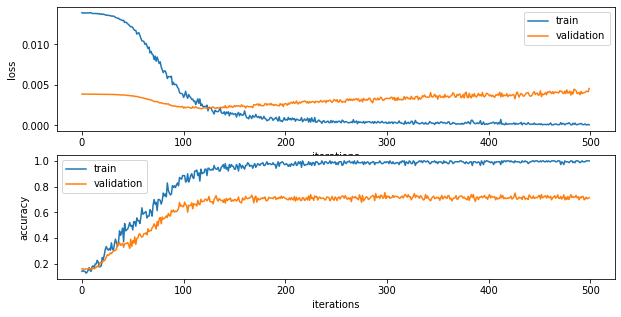

In [22]:
import matplotlib.pyplot as plt
import numpy as np

def display_training_plots(history):
  train_losses, train_accs, val_losses, val_accs = [], [], [], []
  for train_loss, train_acc, val_loss, val_acc in history:
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

  xs = np.arange(len(train_losses))

  plt.figure(figsize=(10, 5))

  plt.subplot(2, 1, 1)
  plt.plot(xs, train_losses, label="train")
  plt.plot(xs, val_losses, label="validation")
  plt.xlabel("iterations")
  plt.ylabel("loss")
  plt.legend(loc="best")

  plt.subplot(2, 1, 2)
  plt.plot(xs, train_accs, label="train")
  plt.plot(xs, val_accs, label="validation")
  plt.xlabel("iterations")
  plt.ylabel("accuracy")
  plt.legend(loc="best")

  _ = plt.show()


display_training_plots(history)

## Evaluation

Now evaluate your trained model on the held out test set. You can reuse the `eval_step()` function that you used for evaluating the model with the validation set during the training.

Report the accuracy value on the test set to 5 decimal places.

In [23]:
_, test_acc = eval_step(model, test_loader, device)
print("Accuracy on test set: {:.5f}".format(test_acc))

Accuracy on test set: 0.73300


## Repeat classification with GAT

Repeat the classification exercise using a Graph Attention layer (`torch_geometric.nn.GATConv`) instead of the GCN layer. Here are the steps.

1. Either copy-paste the previous network and make the necessary changes, or refactor the previous network so it can be subclassed for the new convolution layer.
2. Instantiate the model and set it to the correct `device`.
3. Instantiate the `AdamW` optimizer with the new model parameters.
4. Run the training loop for `NUM_EPOCHS` epochs, capturing the training and validation loss and accuracies.
5. Use the list of tuples to plot the training curves for training and validation loss and accuracies.
6. Compute and report the accuracy of the GAT based GNN against the held-out test set.

In [24]:
from torch_geometric.nn import GATConv

class NodeClassifierGAT(nn.Module):
  def __init__(self, input_dim, num_graph_layers, hidden_dim, output_dim, dropout_pct):

    super(NodeClassifierGAT, self).__init__()

    self.input_dim = input_dim
    self.hidden_dim = hidden_dim
    self.num_graph_layers = num_graph_layers

    self.convs = nn.ModuleList()
    self.convs.append(GATConv(input_dim, hidden_dim))
    for i in range(num_graph_layers - 1):
      self.convs.append(GATConv(hidden_dim, hidden_dim))

    self.dropout_pct = dropout_pct

    self.clf_head = nn.Sequential(
      nn.Linear(hidden_dim, hidden_dim),
      nn.Dropout(dropout_pct),
      nn.Linear(hidden_dim, output_dim)
    )

  def forward(self, data):
    x, edge_index, batch = data.x, data.edge_index, data.batch
    
    for i in range(self.num_graph_layers):
      x = self.convs[i](x, edge_index)
      x = F.relu(x)
      x = F.dropout(x, p=self.dropout_pct)
    
    x = self.clf_head(x)
    return F.log_softmax(x, dim=1)

  def loss(self, pred, label):
    return F.nll_loss(pred, label)


model_gat = NodeClassifierGAT(INPUT_DIM, NUM_GCN_LAYERS, HIDDEN_DIM, OUTPUT_DIM, DROPOUT_PCT)
model_gat = model_gat.to(device)

In [25]:
optimizer_gat = optim.AdamW(model_gat.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
history_gat = train_loop(model_gat, optimizer_gat, train_loader, val_loader, device, NUM_EPOCHS)

EPOCH   1, TRAIN loss: 0.01393, acc: 0.15714, VAL loss: 0.00392, acc: 0.08200
EPOCH  50, TRAIN loss: 0.01141, acc: 0.52857, VAL loss: 0.00347, acc: 0.39400
EPOCH 100, TRAIN loss: 0.00321, acc: 0.87143, VAL loss: 0.00248, acc: 0.64000
EPOCH 150, TRAIN loss: 0.00106, acc: 0.95714, VAL loss: 0.00280, acc: 0.65400
EPOCH 200, TRAIN loss: 0.00104, acc: 0.94286, VAL loss: 0.00309, acc: 0.68400
EPOCH 250, TRAIN loss: 0.00045, acc: 0.97857, VAL loss: 0.00386, acc: 0.67000
EPOCH 300, TRAIN loss: 0.00060, acc: 0.97857, VAL loss: 0.00389, acc: 0.68600
EPOCH 350, TRAIN loss: 0.00051, acc: 0.98571, VAL loss: 0.00409, acc: 0.69000
EPOCH 400, TRAIN loss: 0.00025, acc: 0.98571, VAL loss: 0.00386, acc: 0.69200
EPOCH 450, TRAIN loss: 0.00024, acc: 0.99286, VAL loss: 0.00429, acc: 0.69200
EPOCH 500, TRAIN loss: 0.00017, acc: 0.99286, VAL loss: 0.00461, acc: 0.71200


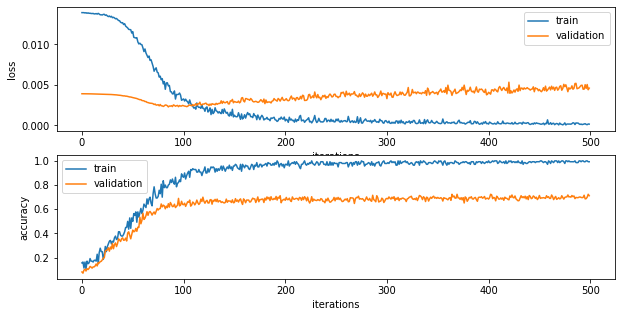

In [26]:
display_training_plots(history_gat)

In [27]:
_, test_acc = eval_step(model_gat, test_loader, device)
print("Accuracy on test set: {:.5f}".format(test_acc))

Accuracy on test set: 0.68200


## Repeat Classification with GraphSAGE

Repeat the classification exercise using a GraphSAGE layer (`torch_geometric.nn.SAGEConv`) instead of the GCN layer. As before, steps are as follows.

1. Either copy-paste the previous network and make the necessary changes, or refactor the previous network so it can be subclassed for the new convolution layer.
2. Instantiate the model and set it to the correct `device`.
3. Instantiate the `AdamW` optimizer with the new model parameters.
4. Run the training loop for `NUM_EPOCHS` epochs, capturing the training and validation loss and accuracies.
5. Use the list of tuples to plot the training curves for training and validation loss and accuracies.
6. Compute and report the accuracy of the GAT based GNN against the held-out test set.


In [28]:
from torch_geometric.nn import SAGEConv

class NodeClassifierSAGE(nn.Module):
  def __init__(self, input_dim, num_graph_layers, hidden_dim, output_dim, dropout_pct):

    super(NodeClassifierSAGE, self).__init__()

    self.input_dim = input_dim
    self.hidden_dim = hidden_dim
    self.num_graph_layers = num_graph_layers

    self.convs = nn.ModuleList()
    self.convs.append(SAGEConv(input_dim, hidden_dim))
    for i in range(num_graph_layers - 1):
      self.convs.append(SAGEConv(hidden_dim, hidden_dim))

    self.dropout_pct = dropout_pct

    self.clf_head = nn.Sequential(
      nn.Linear(hidden_dim, hidden_dim),
      nn.Dropout(dropout_pct),
      nn.Linear(hidden_dim, output_dim)
    )

  def forward(self, data):
    x, edge_index, batch = data.x, data.edge_index, data.batch
    
    for i in range(self.num_graph_layers):
      x = self.convs[i](x, edge_index)
      x = F.relu(x)
      x = F.dropout(x, p=self.dropout_pct)
    
    x = self.clf_head(x)
    return F.log_softmax(x, dim=1)

  def loss(self, pred, label):
    return F.nll_loss(pred, label)


model_sage = NodeClassifierSAGE(INPUT_DIM, NUM_GCN_LAYERS, HIDDEN_DIM, OUTPUT_DIM, DROPOUT_PCT)
model_sage = model_sage.to(device)

In [29]:
optimizer_sage = optim.AdamW(model_sage.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
history_sage = train_loop(model_sage, optimizer_sage, train_loader, val_loader, device, NUM_EPOCHS)

EPOCH   1, TRAIN loss: 0.01393, acc: 0.15714, VAL loss: 0.00389, acc: 0.08000
EPOCH  50, TRAIN loss: 0.01220, acc: 0.43571, VAL loss: 0.00366, acc: 0.32600
EPOCH 100, TRAIN loss: 0.00328, acc: 0.85000, VAL loss: 0.00261, acc: 0.65800
EPOCH 150, TRAIN loss: 0.00070, acc: 0.97143, VAL loss: 0.00299, acc: 0.68400
EPOCH 200, TRAIN loss: 0.00052, acc: 0.98571, VAL loss: 0.00341, acc: 0.71400
EPOCH 250, TRAIN loss: 0.00023, acc: 0.99286, VAL loss: 0.00332, acc: 0.73000
EPOCH 300, TRAIN loss: 0.00033, acc: 0.97857, VAL loss: 0.00340, acc: 0.74400
EPOCH 350, TRAIN loss: 0.00014, acc: 0.98571, VAL loss: 0.00415, acc: 0.72800
EPOCH 400, TRAIN loss: 0.00008, acc: 1.00000, VAL loss: 0.00417, acc: 0.73400
EPOCH 450, TRAIN loss: 0.00008, acc: 1.00000, VAL loss: 0.00445, acc: 0.74000
EPOCH 500, TRAIN loss: 0.00007, acc: 1.00000, VAL loss: 0.00464, acc: 0.72200


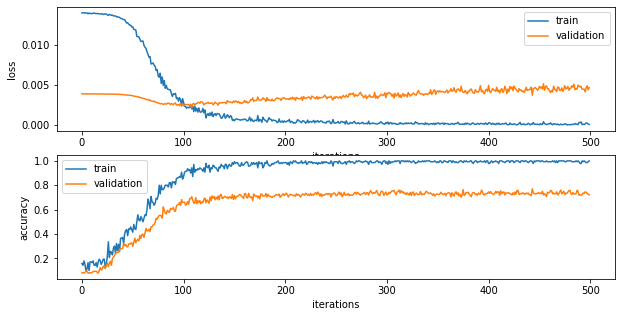

In [30]:
display_training_plots(history_sage)

In [31]:
_, test_acc = eval_step(model_sage, test_loader, device)
print("Accuracy on test set: {:.5f}".format(test_acc))

Accuracy on test set: 0.73500
